# Rethinking Statistics course in Numpyro - Week 2

Lecture 3: Geocentric Models

- [Video](https://youtu.be/h5aPo5wXN8E)
- [Slides](https://speakerdeck.com/rmcelreath/l03-statistical-rethinking-winter-2019)

Lecture 4: Wiggly Orbits

- [Video](https://youtu.be/ENxTrFf9a7c)
- [Slides](https://speakerdeck.com/rmcelreath/l04-statistical-rethinking-winter-2019)

[Proposed problems](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week02.pdf) and [solutions in R](https://github.com/gbosquechacon/statrethinking_winter2019/blob/master/homework/week02_solutions.pdf) for the exercises of the week.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import arviz as az
import seaborn as sns

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Mar 28 2021

Python implementation: CPython
Python version       : 3.9.1
IPython version      : 7.21.0

scipy  : 1.6.1
pandas : 1.2.3
seaborn: 0.11.1
numpy  : 1.20.1
arviz  : 0.11.2
jax    : 0.2.10
numpyro: 0.6.0

Watermark: 2.2.0



In [3]:
sns.set_style('whitegrid')
rng_key = random.PRNGKey(0)

## Short Intro

Example of building a prior manually (kind of a pain):

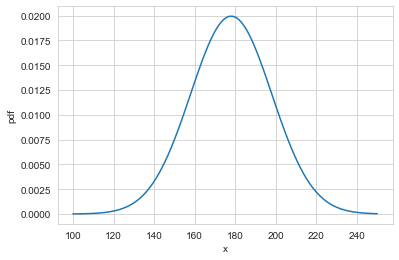

In [4]:
x = np.linspace(100, 250, 100)
pdf = stats.norm.pdf(x, 178, 20)
data = pd.DataFrame({'x':x, 'pdf':pdf})
g = sns.lineplot(data=data, x='x', y='pdf')

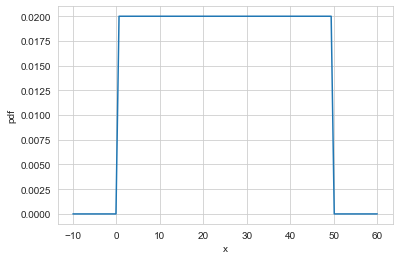

In [5]:
x = np.linspace(-10, 60, 100)
pdf = stats.uniform.pdf(x, 0, 50)
data = pd.DataFrame({'x':x, 'pdf':pdf})
g = sns.lineplot(data=data, x='x', y='pdf')

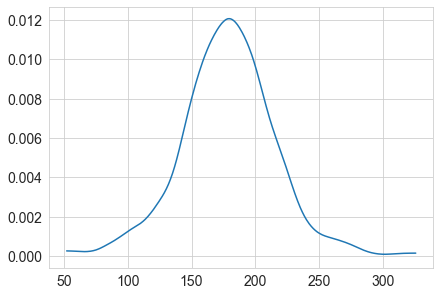

In [6]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
ax = az.plot_kde(prior_h)

## Exercise 1

>The weights listed below were recorded in the !Kung census, but heights were not recorded for the weights 45, 40, 65, 31 and 53. Provide predicted heights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions.

In [7]:
d = pd.read_csv('./dat/Howell1.csv', sep=';', header=0)
d.tail(3)

,height,weight,age,male
541,156.21,54.062497,21.0,0
542,71.12,8.051258,0.0,1
543,158.75,52.531624,68.0,1


In [8]:
aux = (pd.DataFrame(np.array([45, 40, 65, 31, 53]))
       .rename(columns={0:'weight'})
       .assign(expected_height=np.nan)
      )
aux

,weight,expected_height
0,45,NaN
1,40,NaN
2,65,NaN
3,31,NaN
4,53,NaN


Let's get the data. The weights that interest us are all adult weights, so we can analyze only the adults and make a linear approximation.

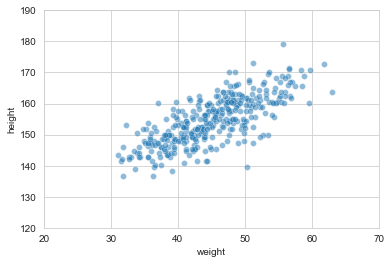

In [9]:
d1 = d.loc[d.age>=18].reset_index(drop=True)
g = sns.scatterplot(data=d1, x='weight', y='height', alpha=0.5)
g.set(xlim=(20,70), ylim=(120,190));

This is the first of many times that a model is defined so I'll take a moment to explain a bit its general structure. First the model is defined and named, in this case as `model`. Then there are four basic sections within it:

1. **Data**: where the data that model needs is defined. Usually, the data is divided in two sets: one for fitting the model ($X_{train}$) and other one for testing it ($X_{test}$). This is very useful for making predictions with the model for data not used for its fitting, something extremely common in Machine Learning. In the course and the book this is usually called out-of-sample prediction but in general Data Science we refer to it as just measuring the accuracy of the model on the test set.

2. **Priors**: where the priors are defined. This priors are the initial distributions our parameters evolve from. They are supposed to represent our knowledge about our system. For instance, a standard deviation can not be negative so we initialize it as a Uniform distribution with lower bound zero. In the course this is mentioned again and again.

3. **Likelihood**: where we define the actual structure of the model, in this case a linear regression (to estimate $\mu$). We also define the output variable, in this case `height_hat`. The "hat" subindex in the output metric of almost all models to express that it is the model estimation of the original variable, in this case `height`.

4. **Prior, trace and posterior**: where the priors are sampled from and where the posteriors are estimated and sampled from. Most of the time we will not need neither the priors or the posterior predictions only the parameters, that are stored in the trace. However, it is a good policy to have in all models to keep all concepts in mind.

In [10]:
def model(weight, height=None):
    # priors
    alpha = numpyro.sample('alpha', dist.Normal(178,20))
    beta = numpyro.sample('beta', dist.Normal(0,10))
    sigma = numpyro.sample('sigma', dist.Normal(0,50))
    # likelihood
    mu = alpha + beta*weight
    numpyro.sample('height_hat', dist.Normal(mu,sigma), obs=height)

In [11]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
mcmc.run(rng_key, weight=d1.weight.values, height=d1.height.values)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:02<00:00, 470.14it/s, 39 steps of size 1.17e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha    114.47      1.97    114.44    111.55    117.98    544.86      1.01
      beta      0.89      0.04      0.89      0.81      0.96    542.10      1.01
     sigma      5.12      0.20      5.11      4.80      5.44    734.41      1.00

Number of divergences: 0


Let's get summaries and traces using both `arviz`. The arviz posterior model can be obtained using only the mcmc model. However, in the present week, all of them (prior, posterior and predictive posterior) are explicitily calculated as record keeping.

In [12]:
#prior_predictor = Predictive(model, num_samples=500)
#prior = prior_predictor(rng_key, weight=d1.weight.values)
prior = Predictive(model, num_samples=500)(rng_key, weight=d1.weight.values)
posterior = mcmc.get_samples()
posterior_pred = Predictive(model, posterior)(rng_key, weight=d1.weight.values)
samples = az.from_numpyro(mcmc, prior=prior, posterior_predictive=posterior_pred)
az.summary(samples, hdi_prob=.89).round(2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,114.47,1.97,111.72,117.98,0.08,0.06,549.0,578.0,1.01
beta,0.89,0.04,0.82,0.95,0.00,0.00,546.0,670.0,1.01
sigma,5.12,0.20,4.82,5.44,0.01,0.00,747.0,808.0,1.00


`arviz` have traceplots functions to see how the distribution of each parameter looks like. There usually are four curves per parameter since four chains is the default when running the model.

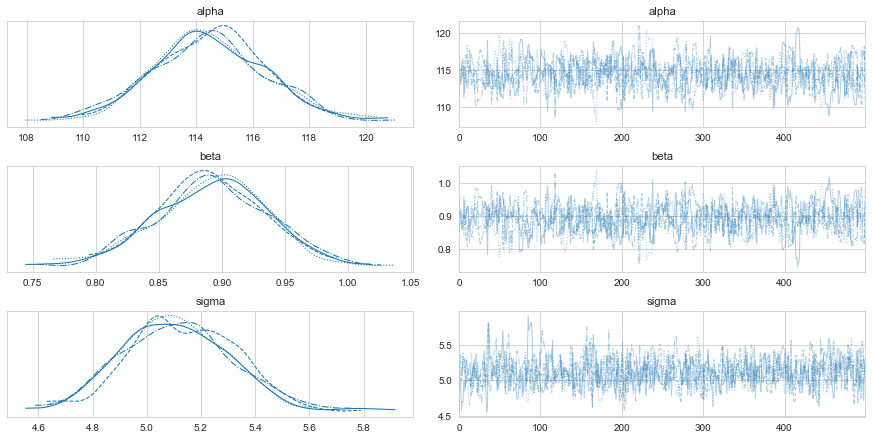

In [13]:
az.plot_trace(samples);

Let's get a predicted value for each of our original samples. This is not requested by the exercise but I think it makes sense first to estimate how good our predictions are in-sample (or in $X_{train}$) before moving to doing predictions out-of-sample ($X_{test}$).

In [14]:
posterior_pred['height_hat'].shape

(2000, 352)

We got 500 draws (times 4 chains) for `height_hat` for each of the original exercise samples. Let's just take the mean for each original sample and build a new column for it in the original dataset.

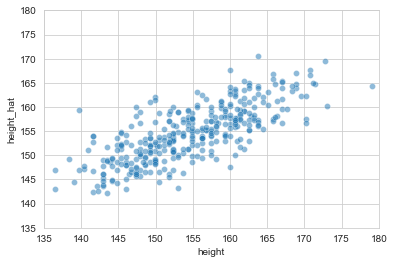

In [15]:
d1 = d1.assign(height_hat=posterior_pred['height_hat'].mean(axis=0))
g = sns.scatterplot(data=d1, x='height', y='height_hat', alpha=0.5)
g.set(xlim=(135,180), ylim=(135,180));

In [16]:
mse = ((d1.height - d1.height_hat)**2).mean(axis=0)
print(f'The RMSE in X_train is {np.sqrt(mse):.2f} cm.')

The RMSE in X_train is 5.07 cm.


I think thats a reasonably good RMSE. Let's build now the High Posterior Density Interval for each original sample.

In [17]:
height_hat_hpd = [az.hdi(s) for s in posterior_pred['height_hat']._value.T]
hpdi = pd.DataFrame(height_hat_hpd).rename({0:'lower_hpdi',1:'upper_hpdi'}, axis=1)
height_hpdi = pd.concat([d1,hpdi], axis = 1)
height_hpdi.tail(5).round(2)

,height,weight,age,male,height_hat,lower_hpdi,upper_hpdi
347,162.56,47.03,27.0,0,156.270004,146.66,165.61
348,142.88,34.25,31.0,0,144.779999,134.38,153.54
349,162.56,52.16,31.0,1,160.970001,151.16,170.18
350,156.21,54.06,21.0,0,162.570007,152.98,172.58
351,158.75,52.53,68.0,1,161.330002,152.14,170.79


Let's finally predict the values requested by the exercise. In this case we had two inputs: `weight` and `height` but actually only have information regarding `weight` for our new individuals so we only update this variable. 

In [18]:
posterior_pred = Predictive(model, posterior)(rng_key, weight=aux.weight.values)
height_hat_hpd = [az.hdi(s) for s in posterior_pred['height_hat']._value.T]
expect_height_hpdi = pd.DataFrame(height_hat_hpd).rename({0:'lower_hpdi',1:'upper_hpdi'}, axis=1)
expect_height_hpdi['expected_height'] = posterior_pred['height_hat']._value.mean(axis=0)
expect_height_hpdi

,lower_hpdi,upper_hpdi,expected_height
0,145.133621,164.813995,154.729813
1,141.117462,159.772797,150.121811
2,162.620148,181.900589,172.578064
3,132.816406,152.911713,142.068268
4,151.819717,171.329407,161.698120


## Exercise 2

>Model the relationship between `height` (cm) and the natural logarithm of weight (log-kg): `log(weight)`. Use the entire `Howell1` data frame, all 544 rows, adults and non-adults. Use any model type from Chapter 4 (from the book) that you think useful: an ordinary linear regression, a polynomial or a spline. Plot the posterior predictions against the raw data.

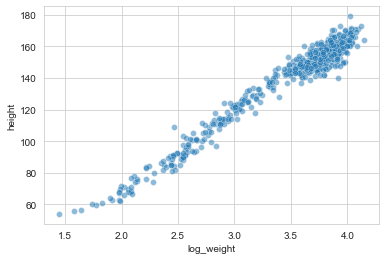

In [19]:
d2 = d.assign(log_weight = np.log(d.weight))
g = sns.scatterplot(data=d2, x='log_weight', y='height', alpha=0.5)

In [20]:
def model(weight, height=None):
    # priors
    alpha = numpyro.sample('alpha', dist.Normal(178,20))
    beta = numpyro.sample('beta', dist.Normal(0,1))
    sigma = numpyro.sample('sigma', dist.Normal(0,50))
    # likelihood
    mu = alpha + beta*weight
    numpyro.sample('height_hat', dist.Normal(mu,sigma), obs=height)

In [21]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
mcmc.run(rng_key, weight=d2.log_weight.values, height=d2.height.values)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:02<00:00, 459.37it/s, 15 steps of size 1.19e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     87.47      4.38     87.25     80.02     94.65    474.59      1.01
      beta     14.80      1.24     14.85     12.76     16.85    477.18      1.01
     sigma     19.34      0.92     19.28     17.89     20.91    483.59      1.01

Number of divergences: 0


Let's get traces using both `az`.

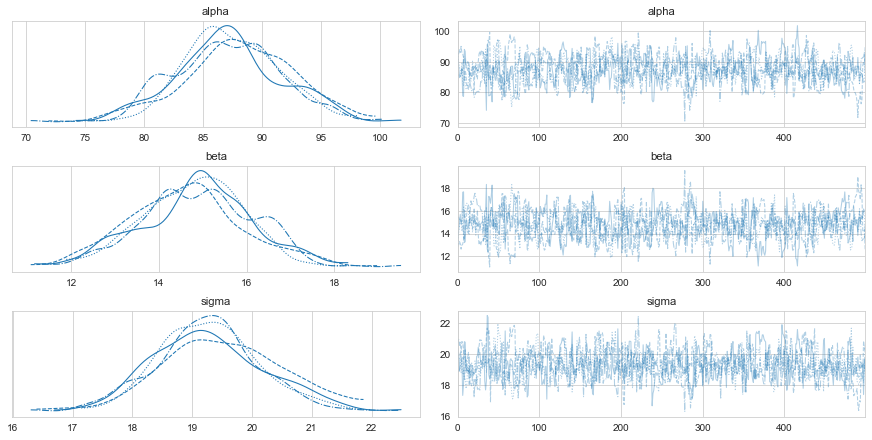

In [22]:
prior = Predictive(model, num_samples=500)(rng_key, weight=d2.log_weight.values)
posterior = mcmc.get_samples()
posterior_pred = Predictive(model, posterior)(rng_key, weight=d2.log_weight.values)
samples = az.from_numpyro(mcmc, posterior_predictive=posterior_pred)
az.plot_trace(samples);

Just as the previous exercise, we recover the mean of height_hat for each sample and the High Posterior Density interval for each sample as well.

In [23]:
d21 = d2.assign(height_hat=posterior_pred['height_hat']._value.mean(axis=0))
hpdi = [az.hdi(s) for s in posterior_pred['height_hat']._value.T]
hpdi = pd.DataFrame(hpdi).rename({0:'lower_hpdi',1:'upper_hpdi'}, axis=1)
d21 = pd.concat([d21, hpdi], axis=1).sort_values(by=['weight'])

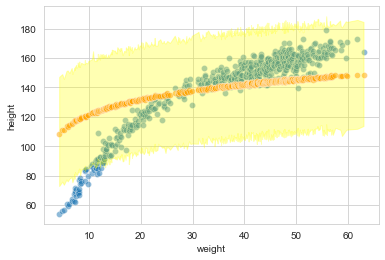

In [24]:
g = sns.scatterplot(data=d21, x='weight', y='height', alpha=0.5)
g.fill_between(d21.weight, d21.lower_hpdi, d21.upper_hpdi, color='yellow', alpha=0.3)
sns.scatterplot(data=d21, x='weight', y='height_hat', color='orange', alpha=0.5);

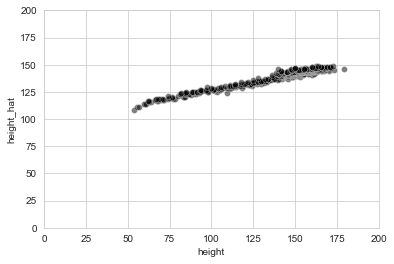

In [25]:
g = sns.scatterplot(data=d21, x='height', y='height_hat', color='black', alpha=0.5)
g.set(xlim=(0,200), ylim=(0,200));

Results are meh. Let's see what happens when we take a polynomial regression of second degree.

In [26]:
d2 = d.assign(weight_2=d2.weight**2)
d2.head(3)

,height,weight,age,male,weight_2
0,151.765,47.825606,63.0,1,2287.288637
1,139.700,36.485807,63.0,0,1331.214076
2,136.525,31.864838,65.0,0,1015.367901


In [27]:
def model(weight, height=None):
    # priors
    alpha = numpyro.sample('alpha', dist.Normal(178,20))
    beta1 = numpyro.sample('beta1', dist.Normal(0,1))
    beta2 = numpyro.sample('beta2', dist.Normal(0,1))
    sigma = numpyro.sample('sigma', dist.Normal(0,50))
    # likelihood
    mu = alpha + beta1*weight + beta2*(weight**2)
    numpyro.sample('height_hat', dist.Normal(mu,sigma), obs=height)

In [28]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
mcmc.run(rng_key, weight=d2.weight.values, height=d2.height.values)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:02<00:00, 429.34it/s, 119 steps of size 1.82e-02. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     46.51      1.21     46.51     44.46     48.36    240.61      1.01
     beta1      4.16      0.09      4.15      4.00      4.28    255.38      1.02
     beta2     -0.04      0.00     -0.04     -0.04     -0.04    287.89      1.02
     sigma      5.79      0.18      5.79      5.52      6.09   1100.46      1.00

Number of divergences: 0


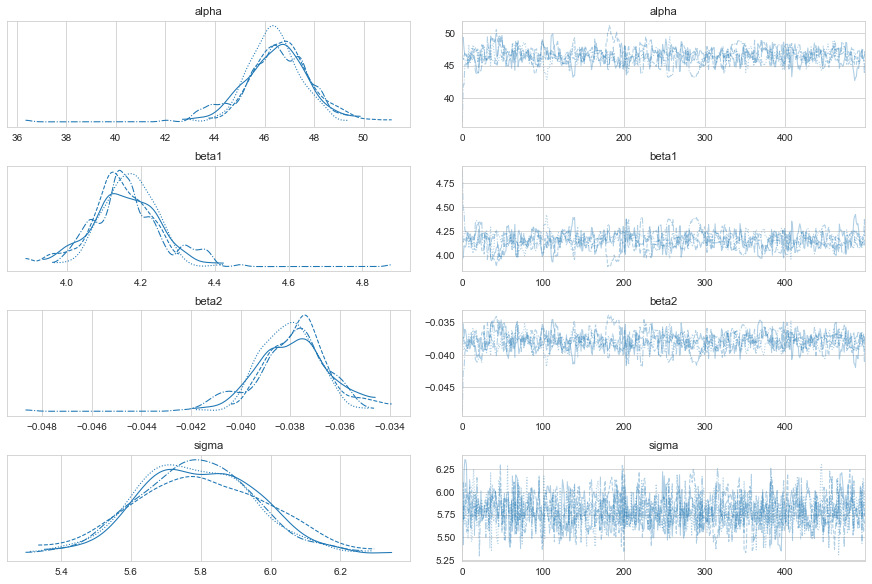

In [29]:
prior = Predictive(model, num_samples=500)(rng_key, weight=d2.weight.values)
posterior = mcmc.get_samples()
posterior_pred = Predictive(model, posterior)(rng_key, weight=d2.weight.values)
samples = az.from_numpyro(mcmc, prior=prior, posterior_predictive=posterior_pred)
az.plot_trace(samples);

In [30]:
d22 = d2.assign(height_hat=posterior_pred['height_hat']._value.mean(axis=0))
hpdi = [az.hdi(s) for s in posterior_pred['height_hat']._value.T]
hpdi = pd.DataFrame(hpdi).rename({0:'lower_hpdi',1:'upper_hpdi'}, axis=1)
d22 = pd.concat([d22, hpdi], axis=1).sort_values(by=['weight'])

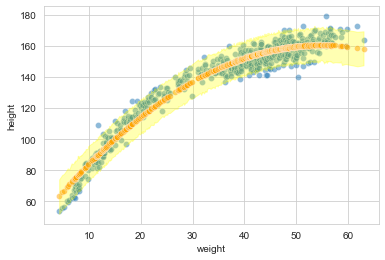

In [31]:
g = sns.scatterplot(data=d22, x='weight', y='height', alpha=0.5)
g.fill_between(d22.weight, d22.lower_hpdi, d22.upper_hpdi, color='yellow', alpha=0.3)
sns.scatterplot(data=d22, x='weight', y='height_hat', color='orange', alpha=0.5);

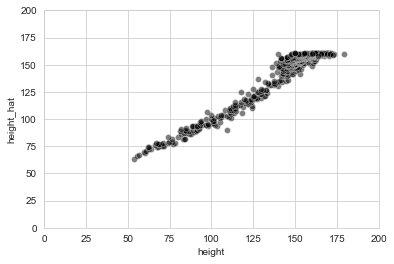

In [32]:
g = sns.scatterplot(data=d22, x='height', y='height_hat', color='black', alpha=0.5)
g.set(xlim=(0,200), ylim=(0,200));

Much better now.

## Exercise 3

> Plot the prior predictive distribution for the polynomial regression model in Chapter 4 (_just what we did in the previous exercise_). You can modify the the code that plots the linear regression prior predictive distribution. 20 or 30 parabolas from the prior should suffice to show where the prior probability resides. Can you modify the prior distributions of `alpha`, `beta1`, and `beta2` so that the prior predictions stay within the biologically reasonable outcome space? That is to say: Do not try to fit the data by hand. But do try to keep the curves consistent with what you know about height and weight, before seeing these exact data.

In [33]:
# taking data from previous section
d3 = d22
prior31 = prior

Let's just recover the values from the priors manually and build a pandas dataframe.

In [34]:
df = pd.DataFrame()
df = df.assign(height_hat = prior31['height_hat'].mean(axis=1),
               alpha = prior31['alpha'],
               sigma = prior31['sigma'],
               beta1 = prior31['beta1'],
               beta2 = prior31['beta2']
               )
df.head()

,height_hat,alpha,sigma,beta1,beta2
0,-307.154053,176.774063,-9.700806,-0.220740,-0.320860
1,-1407.233032,205.809219,31.884762,-1.843794,-1.042232
2,225.267273,166.899307,33.320087,0.745229,0.021352
3,-1422.809326,157.829819,-65.854927,-1.130443,-1.039238
4,-1771.628784,179.733871,23.137325,0.008882,-1.314785


In [35]:
df.mean() # it checks out with the az.summary results

height_hat    109.950752
alpha         176.028534
sigma           0.565620
beta1          -0.103036
beta2          -0.042002
dtype: float32

Now some data wrangling.

In [36]:
priors = pd.DataFrame()
for i in range(30): # 30 parabolas is fine
    priors['prior_'+str(i)] = df.loc[i,'alpha'] + df.loc[i,'beta1'] * d3['weight'] + df.loc[i,'beta2'] * d3['weight_2']

aux = pd.concat([d3.weight, priors], axis=1)
aux_plot = aux.melt(id_vars=['weight'],
                  value_vars=list(aux.columns)[1:],
                  var_name='prior',
                  value_name='height')

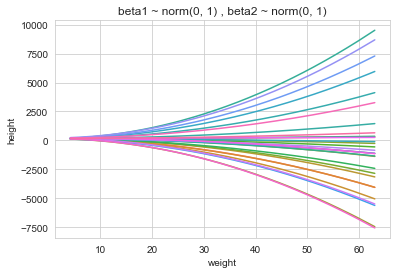

In [37]:
g = sns.lineplot(data=aux_plot, x='weight', y='height', hue='prior', ci=None, legend=False)
g.set(title='beta1 ~ norm(0, 1) , beta2 ~ norm(0, 1)');

Recall that the world's tallest person was 270 cm tall. The prior curvature has silly shapes. That can't be right. The basic problem is that `beta2` needs to be negative to make the curve bend down, but `beta1` has to also change in order to move the maximum height to the right. It's all a bit confusing, and is they key reason that working with polynomial models is so hard. The prior on the right below can only bend down, but I've made the linear model `a + beta1 * weight_c - beta2 * weight_c_2` and given `beta2` a logNormal prior.

In [38]:
d3 = d
d3 = d3.assign(weight_c=pd.Series(d3.weight - d3.weight.mean())/d3.weight.std())
d3 = d3.assign(weight_c_2=pd.Series(d3.weight_c**2))

In [39]:
def model(weight, height=None):
    # priors
    alpha = numpyro.sample('alpha', dist.Normal(178,20))
    beta1 = numpyro.sample('beta1', dist.LogNormal(2,1))
    beta2 = numpyro.sample('beta2', dist.LogNormal(1,1))
    sigma = numpyro.sample('sigma', dist.Normal(0,50))
    # likelihood
    mu = alpha + beta1*weight - beta2*(weight**2)
    numpyro.sample('height_hat', dist.Normal(mu,sigma), obs=height)

In [40]:
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=4, chain_method='sequential')
mcmc.run(rng_key, weight=d3.weight_c.values, height=d3.height.values)
mcmc.print_summary()

sample: 100%|██████████| 1000/1000 [00:02<00:00, 420.64it/s, 7 steps of size 4.57e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha    146.67      0.37    146.67    146.09    147.31   1088.09      1.00
     beta1     21.40      0.29     21.40     20.92     21.84   1101.92      1.00
     beta2      8.41      0.28      8.41      7.95      8.83    940.05      1.00
     sigma      5.78      0.17      5.78      5.50      6.05   1487.56      1.00

Number of divergences: 0


In [41]:
prior32 = Predictive(model, num_samples=500)(rng_key, weight=d3.weight_c.values)
df = pd.DataFrame()
df = df.assign(height_hat = prior32['height_hat'].mean(axis=1),
               alpha = prior32['alpha'],
               sigma = prior32['sigma'],
               beta1 = prior32['beta1'],
               beta2 = prior32['beta2']
               )
df.head()

,height_hat,alpha,sigma,beta1,beta2
0,175.013138,176.774063,-9.700806,5.925468,1.972182
1,204.528397,205.809219,31.884762,1.169068,0.958647
2,164.262878,166.899307,33.320087,15.568175,2.776947
3,159.103073,157.829819,-65.854927,2.385855,0.961522
4,178.956604,179.733871,23.137325,7.454978,0.729946


In [42]:
priors = pd.DataFrame()
for i in range(30): # 30 parabolas is fine
    priors['prior_'+str(i)] = df.loc[i,'alpha'] + df.loc[i,'beta1'] * d3['weight_c'] - df.loc[i,'beta2'] * d3['weight_c']

aux = pd.concat([d3.weight, priors], axis=1)
aux_plot = aux.melt(id_vars=['weight'],
                  value_vars=list(aux.columns)[1:],
                  var_name='prior',
                  value_name='height')

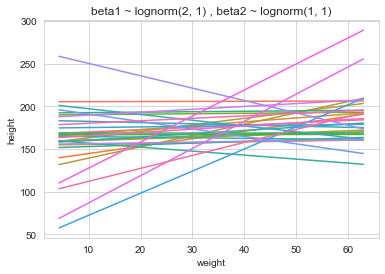

In [43]:
g = sns.lineplot(data=aux_plot, x='weight', y='height', hue='prior', ci=None, legend=False)
g.set(title='beta1 ~ lognorm(2, 1) , beta2 ~ lognorm(1, 1)');

A key problem in getting reasonable curves here is that obviously a and `beta1` and `beta2` are correlated in the family of reasonable curves. But the priors are uncorrelated, they are independent of one another. Still, if you can get independent priors to at least live within some reasonably space of outcome values, that's a lot better than flat priors. This is a general phenomenon with “flat” priors: Once the predictor is at all complicated, “flat” does not imply “no relationship.” Do any of the priors above make a difference for inference in this sample? No. There is a lot of data and the model is quite simple, in terms of the way that parameters relate to predictions. This will not always be the case.